**Read the processed dataset**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import contractions
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pickle
import io
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sn

D:\Anaconda\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
proc_dateset2 = pd.read_csv('Processes-dataset.csv')

proc_dateset2.drop(proc_dateset2.columns[0], axis=1, inplace=True)

proc_dateset2

,review,sentiment
0,one reviewer mention watch oz episode hook rig...,1
1,wonderful little production br br film techniq...,1
2,think wonderful way spend time hot summer week...,1
3,basically family little boy jake think zombie ...,0
4,petter mattei love time money visually stunnin...,1
...,...,...
49571,think movie right good job creative original f...,1
49572,bad plot bad dialogue bad acting idiotic direc...,0
49573,catholic teach parochial elementary school nun...,0
49574,go disagree previous comment side maltin one s...,0


In [5]:
proc_dateset3 = proc_dateset2.iloc[0:15000]
proc_dateset3

,review,sentiment
0,one reviewer mention watch oz episode hook rig...,1
1,wonderful little production br br film techniq...,1
2,think wonderful way spend time hot summer week...,1
3,basically family little boy jake think zombie ...,0
4,petter mattei love time money visually stunnin...,1
...,...,...
14995,never understood appeal garbo always come acro...,0
14996,entirely bad movie plot new house build next d...,0
14997,big md fan call like see film limp along plot ...,0
14998,pure crap probably bad biblical theme film eve...,0


**Split data to train, test and validate**

In [6]:
x, x_test, y, y_test = train_test_split(
    proc_dateset3['review'],
    proc_dateset3['sentiment'],
    test_size=0.2,
    random_state= 42
)

In [7]:
x_train, x_val, y_train, y_val = train_test_split(
    x,
    y,
    test_size=0.33,
    random_state= 42
)

**Get number of rows for each subset**

In [8]:
print(x_train.shape[0])
print(x_val.shape[0])
print(x_test.shape[0])

8040
3960
3000


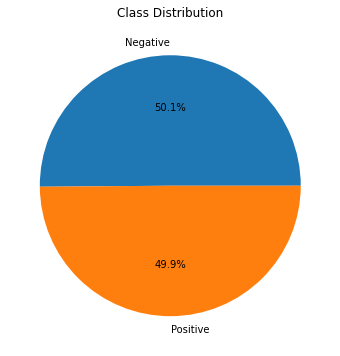

In [9]:
# Map the numerical labels to corresponding categories
classes = {0: 'Negative', 1: 'Positive'}

labels_description = np.array([classes[label] for label in y_train])

# Count the occurrences of each class in the 'labels_description' array
class_counts = np.unique(labels_description, return_counts=True)

# Create a pie chart
plt.figure(figsize=(10, 6))
plt.pie(class_counts[1], labels=class_counts[0], autopct='%1.1f%%')
plt.title('Class Distribution')
plt.show()

**Encode text using tfidf**

In [10]:
# Create the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the train data
tf_x_train = tfidf_vectorizer.fit_transform(x_train)

In [11]:
print('Number of features is:\n',tfidf_vectorizer.get_feature_names_out().shape)

Number of features is:
 (40574,)


In [12]:
# Transform validation and test data
tf_x_val = tfidf_vectorizer.transform(x_val)
tf_x_test = tfidf_vectorizer.transform(x_test)

## <font color='orange'> ***Train models***</font>

In [47]:
def evaluate_model(clf, x_train, y_train, x_val, y_val):
    clf.fit(x_train, y_train)
    y_pred_train = clf.predict(x_train)
    y_pred_val = clf.predict(x_val)
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_val = accuracy_score(y_val, y_pred_val)
    return acc_train, acc_val

In [48]:
def plot_conf_matrix(model, X_val, y_val):
    y_pred_val = model.predict(X_val)
    cf = confusion_matrix(y_val, y_pred_val)
    cf_row_sum = cf.sum(axis=1, keepdims=True)
    cf_normalized = cf/cf_row_sum
    sn.heatmap(cf_normalized, annot=True, cmap='Blues')
    plt.show()

## <font color='orange'> ***Random Forest Model***</font>

### Initial model

In [49]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
evaluate_model(model, tf_x_train, y_train, tf_x_val, y_val)

(1.0, 0.8315656565656566)

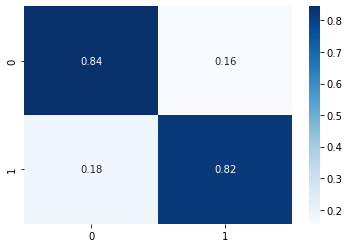

In [50]:
plot_conf_matrix(model, tf_x_val, y_val)

### Hyper-parameter tuning (n_estimators)


In [51]:
n_estimators_values = [10, 50, 100, 200, 300, 400, 500]

acc_train_values = []
acc_val_values = []

for n_estimators in n_estimators_values:
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=3, random_state=0)
    acc_train, acc_val = evaluate_model(model, tf_x_train, y_train, tf_x_val, y_val)
    acc_train_values.append(acc_train)
    acc_val_values.append(acc_val)
    

In [52]:
results = pd.DataFrame({
    'n_estimators': n_estimators_values,
    'acc_train': acc_train_values,
    'acc_val': acc_val_values,
})

results

,n_estimators,acc_train,acc_val
0,10,0.653483,0.638889
1,50,0.789428,0.746212
2,100,0.825373,0.786111
3,200,0.850249,0.815909
4,300,0.854726,0.822222
5,400,0.853607,0.825000
6,500,0.857338,0.827525


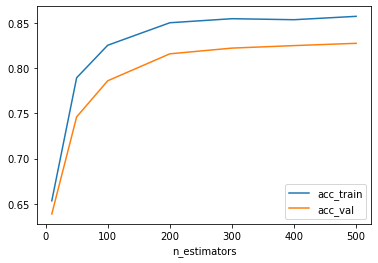

In [53]:
results.plot(x='n_estimators', y=['acc_train', 'acc_val'])
plt.show()

In [54]:
max_depth_values = [1, 2, 3, 4, 5, 6, 7, 8, 9]
acc_train_values = []
acc_val_values = []

for max_depth in max_depth_values:
    model = RandomForestClassifier(n_estimators=200, max_depth=max_depth, random_state=0)
    acc_train, acc_val = evaluate_model(model, tf_x_train, y_train, tf_x_val, y_val)
    acc_train_values.append(acc_train)
    acc_val_values.append(acc_val)
    

In [55]:
results = pd.DataFrame({
    'max_depth': max_depth_values,
    'acc_train': acc_train_values,
    'acc_val': acc_val_values,
})

results

,max_depth,acc_train,acc_val
0,1,0.793284,0.767172
1,2,0.828607,0.809343
2,3,0.850249,0.815909
3,4,0.860697,0.818434
4,5,0.868532,0.818434
5,6,0.877114,0.822475
6,7,0.894154,0.823990
7,8,0.899129,0.825253
8,9,0.905721,0.833333


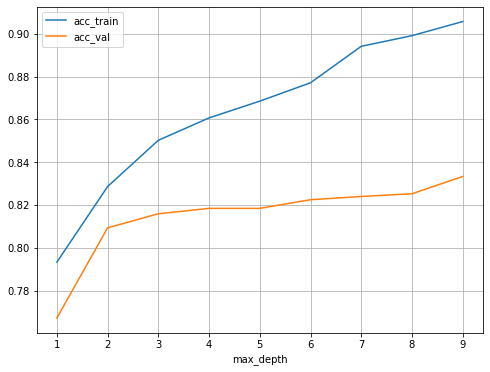

In [56]:
results.plot(x='max_depth', y=['acc_train', 'acc_val'], figsize=(8, 6))
plt.grid(axis='both')
plt.xticks(max_depth_values)
plt.show()

### Use the Best Prameters

In [57]:
model_best = RandomForestClassifier(n_estimators=200, max_depth=2, random_state=0)
evaluate_model(model_best, tf_x_train, y_train, tf_x_val, y_val)

(0.8286069651741294, 0.8093434343434344)

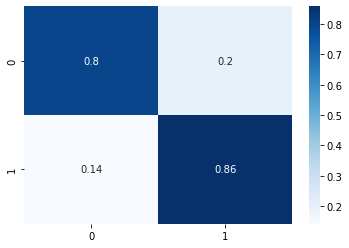

In [58]:
plot_conf_matrix(model_best, tf_x_train, y_train)